In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

etfs = ['PG','MA', 'BLK','GM']
years = 20
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)
returns = yf.download(etfs, start=startDate, end=endDate)['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [2]:
log_returns = np.log(returns / returns.shift(1))
log_returns = log_returns.dropna()

In [3]:
weights = np.array([0.12,0.10,0.15,0.06])
historical_returns = (log_returns * weights).sum(axis =1)

# Calculate the average of the historical returns
average_log_return = historical_returns.mean()

# Annualize the log return (multiply by the number of trading days in a year)
annualized_log_return = average_log_return * 365

# Convert the annualized log return to an arithmetic return (since it's compounded)
annualized_return = np.exp(annualized_log_return) - 1

# Print the result
print(f'Annualized Weighted Return (with compounding, without inflation): {annualized_return:.4f}')


Annualized Weighted Return (with compounding, without inflation): 0.0972


In [4]:
days = 365

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()

In [5]:
# Calculate the standard deviation of the log returns (historical_returns)
returns_std = range_returns.std()

print(f'Portfolio {days} days Standard Deviation: {returns_std:.4f}')


Portfolio 365 days Standard Deviation: 0.0766


In [6]:

# Calculate Sharpe Ratio (assuming risk-free rate of 0.0439 for example)
risk_free_rate = 0.0439  # You could also fetch this dynamically
sharpe_ratio = (annualized_return - risk_free_rate) / returns_std
print(f'Portfolio Sharpe Ratio: {sharpe_ratio:.4f}')

Portfolio Sharpe Ratio: 0.6962


In [7]:
# ... after historical returns calculation ...

def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = cumulative / rolling_max - 1
    return drawdowns.min()

max_drawdown = calculate_max_drawdown(historical_returns)
print(f'Maximum Drawdown: {max_drawdown:.4%}')


Maximum Drawdown: -20.9932%


In [8]:
correlation_matrix = log_returns.corr()
# ... after weights calculation ...
def calculate_diversification_score(weights, correlation_matrix):
    """
    Calculate diversification score and percentage for a portfolio.

    Args:
        weights (array-like): Portfolio weights.
        correlation_matrix (pd.DataFrame or np.ndarray): Asset correlation matrix.

    Returns:
        tuple: Diversification score and percentage of maximum possible diversification.
    """
    # Ensure weights are a numpy array
    weights = np.array(weights)
    
    # Calculate concentration (sum of squared weights)
    concentration = np.sum(weights ** 2)
    
    # Calculate weighted average correlation
    weighted_correlation = np.dot(np.dot(weights, correlation_matrix), weights)
    
    # Diversification score
    div_score = 1 / (concentration * weighted_correlation)
    
    # Maximum possible score (number of assets with equal weights and no correlations)
    max_score = len(weights)
    
    # Calculate percentage of maximum diversification
    div_percentage = (div_score / max_score) * 100
    
    return div_score, div_percentage

# Calculate diversification
div_score, div_percentage = calculate_diversification_score(weights, correlation_matrix)

# Print diversification analysis
print(f"\nDiversification Analysis:")
print(f"Diversification Score: {div_score:.2f}")
print(f"Diversification Percentage: {div_percentage:.2f}%")

# Interpretation
if div_score > len(weights):
    print("✓ Excellent diversification! Assets have favorable correlations.")
elif div_score > len(weights) * 0.7:
    print("✓ Good diversification. Consider additional decorrelation for improvement.")
else:
    print("! Low diversification. Your portfolio may be concentrated or highly correlated.")



Diversification Analysis:
Diversification Score: 171.16
Diversification Percentage: 4279.11%
✓ Excellent diversification! Assets have favorable correlations.


In [9]:
confidence_interval = 0.95

VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100))
cvar = -range_returns[range_returns <= -VaR].mean()

# Output the results
print(f"VaR: There is a {(1-confidence_interval)*100:.2f}% chance that the portfolio loss will exceed {VaR*100:.2f}% in {days} days.")
print(f"CVaR: If the loss exceeds the VaR, the average loss is {cvar*100:.2f}% in {days} days.")

VaR: There is a 5.00% chance that the portfolio loss will exceed 5.84% in 365 days.
CVaR: If the loss exceeds the VaR, the average loss is 8.17% in 365 days.


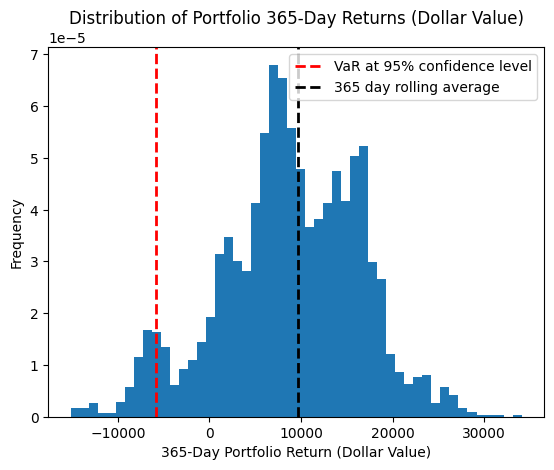

In [10]:
return_window = days
range_returns = historical_returns.rolling(window=return_window).sum()
range_returns = range_returns.dropna()
portfolio_value = 100000
range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR*portfolio_value, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.axvline(annualized_return*portfolio_value, color='black', linestyle='dashed', linewidth=2, label='365 day rolling average')
plt.legend()
plt.show()